In [36]:
# ==== Import Library ====
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
from tqdm import tqdm

In [47]:
# =================== Konfigurasi Global ===================
IMG_SIZE = 128
EPOCHS = 5
BATCH_SIZE = 32
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# =================== Load Path Dataset ===================
base_dir = 'thelast'  # Update path sesuai dengan dataset
class_order = ['CNV', 'DME', 'DRUSEN', 'NORMAL']  # Update label sesuai dengan dataset

# =================== Snapshot Dataset ===================
data = []
for label in class_order:
    folder = os.path.join(base_dir, 'train', label)  # Menggunakan folder train
    if os.path.isdir(folder):
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder, fname)
                if cv2.imread(img_path) is not None:
                    data.append({'file_path': os.path.abspath(img_path), 'label': label})
df = pd.DataFrame(data)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_28656\1955442394.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='pastel', order=class_order)


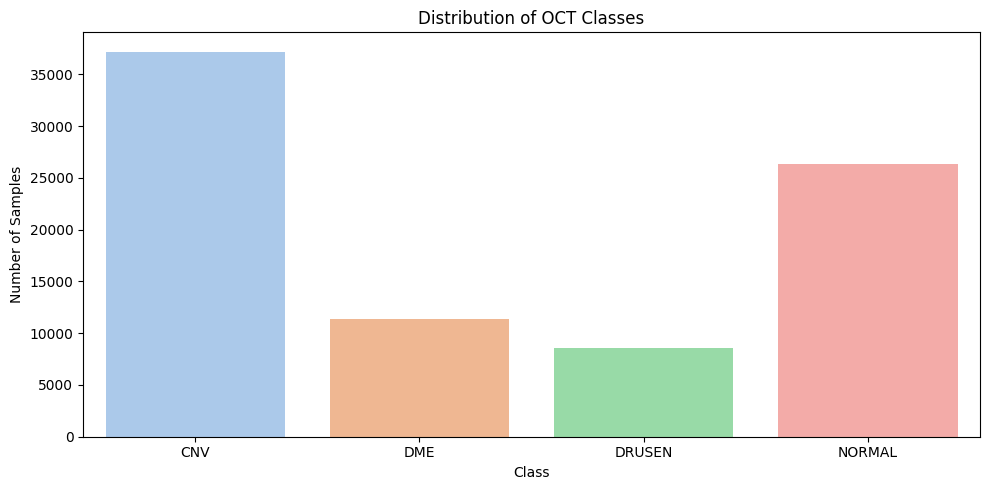

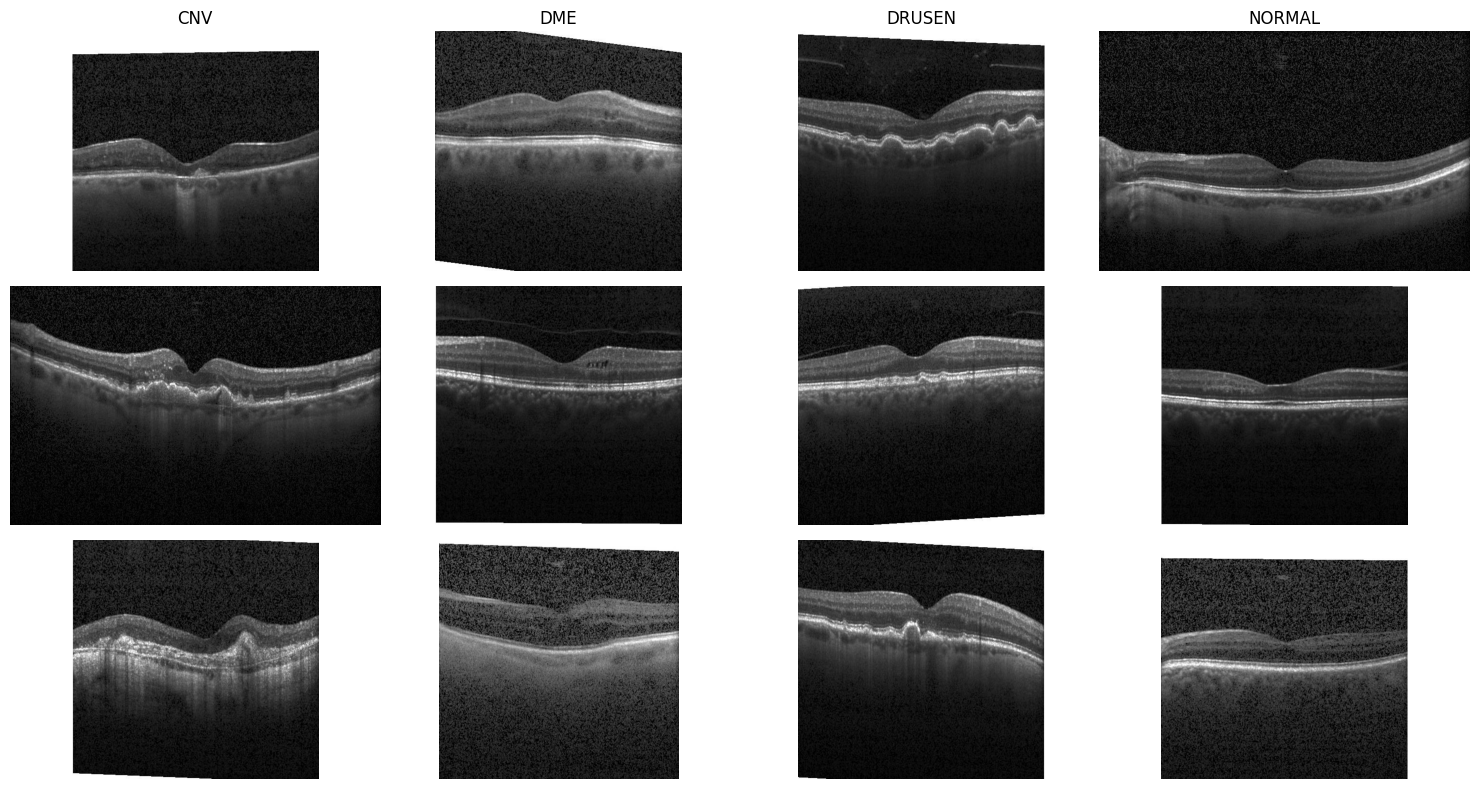

In [38]:
# =================== EDA: Distribusi dan Contoh Gambar ===================
def visualize_class_distribution(df, class_order):
    plt.figure(figsize=(10, 5))
    sns.countplot(x='label', data=df, palette='pastel', order=class_order)
    plt.title("Distribution of OCT Classes")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.savefig("eda_class_distribution.png")
    plt.show()

def visualize_sample_images(df, class_order, samples_per_class=3):
    plt.figure(figsize=(15, 8))
    for j, label in enumerate(class_order):
        samples = df[df['label'] == label].sample(samples_per_class, random_state=42)
        for i, (_, row) in enumerate(samples.iterrows()):
            img = cv2.imread(row['file_path'])  # Menggunakan cv2 untuk membaca gambar
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Mengonversi dari BGR ke RGB
            plt.subplot(samples_per_class, len(class_order), i * len(class_order) + j + 1)
            plt.imshow(img)
            if i == 0:
                plt.title(label)
            plt.axis('off')
    plt.tight_layout()
    plt.savefig("eda_sample_images.png")
    plt.show()

visualize_class_distribution(df, class_order)
visualize_sample_images(df, class_order, samples_per_class=3)

In [39]:
# =================== Undersampling setelah EDA ===================
df = df.groupby('label').apply(lambda x: x.sample(n=min(len(x), 3000), random_state=42)).reset_index(drop=True)

# Label Encoding
le = LabelEncoder()
y = le.fit_transform(df['label'])

# =================== Image Preprocessing Function ===================
def preprocess_oct_image(img_path):
    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    equalized = clahe.apply(gray)
    laplacian = cv2.Laplacian(equalized, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)
    color = cv2.applyColorMap(laplacian, cv2.COLORMAP_JET)
    resized = cv2.resize(color, (IMG_SIZE, IMG_SIZE))
    return resized

# =================== Denoising dan Resize Gambar ===================
input_path = os.path.join(base_dir, 'train')
output_path = 'py_processed_train'
target_size = (IMG_SIZE, IMG_SIZE)

for class_name in class_order:
    input_class_path = os.path.join(input_path, class_name)
    output_class_path = os.path.join(output_path, class_name.lower())
    os.makedirs(output_class_path, exist_ok=True)
    for filename in os.listdir(input_class_path):
        image_path = os.path.join(input_class_path, filename)
        output_image_path = os.path.join(output_class_path, filename)
        image = cv2.imread(image_path)
        denoised_image = cv2.GaussianBlur(image, (5,5), 0)
        resized_denoised_image = cv2.resize(denoised_image, target_size)
        cv2.imwrite(output_image_path, resized_denoised_image)

# =================== Augmentasi dan Dataset Pipeline ===================
data_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(root=output_path, transform=data_transforms)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# =================== Simpan LabelEncoder ===================
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_28656\1456588963.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label').apply(lambda x: x.sample(n=min(len(x), 3000), random_state=42)).reset_index(drop=True)


In [43]:
# =================== Build Baseline Model ===================
class BaselineModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(BaselineModel, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
        self.fc1 = torch.nn.Linear(1280, 256)
        self.dropout = torch.nn.Dropout(0.1)
        self.fc2 = torch.nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)            # (B, 1280, H, W)
        x = x.mean(dim=[2, 3])                     # Global Average Pooling (B, 1280)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# =================== Build Advanced Model ===================
class AdvancedModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(AdvancedModel, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = True
        self.fc1 = torch.nn.Linear(1280, 256)
        self.dropout = torch.nn.Dropout(0.1)
        self.fc2 = torch.nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = x.mean(dim=[2, 3])                     # Global Average Pooling (B, 1280)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Training Baseline Model...


Epoch 1/5 [Validation]: 100%|██████████| 522/522 [10:14<00:00,  1.18s/it, val_accuracy=74.9, val_loss=0.677]


Epoch 1/5 Summary: Train Loss: 0.7420, Train Acc: 0.7196, Val Loss: 0.6690, Val Acc: 0.7492


Epoch 2/5 [Validation]: 100%|██████████| 522/522 [07:44<00:00,  1.12it/s, val_accuracy=74.5, val_loss=0.856]


Epoch 2/5 Summary: Train Loss: 0.7122, Train Acc: 0.7318, Val Loss: 0.6847, Val Acc: 0.7452


Epoch 3/5 [Validation]: 100%|██████████| 522/522 [07:33<00:00,  1.15it/s, val_accuracy=74.9, val_loss=0.592]


Epoch 3/5 Summary: Train Loss: 0.7010, Train Acc: 0.7364, Val Loss: 0.6760, Val Acc: 0.7489


Epoch 4/5 [Validation]: 100%|██████████| 522/522 [07:47<00:00,  1.12it/s, val_accuracy=75.1, val_loss=0.789]


Epoch 4/5 Summary: Train Loss: 0.6904, Train Acc: 0.7376, Val Loss: 0.6640, Val Acc: 0.7506


Epoch 5/5 [Validation]: 100%|██████████| 522/522 [08:01<00:00,  1.08it/s, val_accuracy=75.9, val_loss=0.717]


Epoch 5/5 Summary: Train Loss: 0.6955, Train Acc: 0.7379, Val Loss: 0.6461, Val Acc: 0.7589
Training Advanced Model...


Epoch 1/5 [Validation]: 100%|██████████| 522/522 [10:37<00:00,  1.22s/it, val_accuracy=85.7, val_loss=0.606] 


Epoch 1/5 Summary: Train Loss: 0.6174, Train Acc: 0.7716, Val Loss: 0.3924, Val Acc: 0.8573


Epoch 2/5 [Validation]: 100%|██████████| 522/522 [10:39<00:00,  1.23s/it, val_accuracy=88, val_loss=0.609]   


Epoch 2/5 Summary: Train Loss: 0.3972, Train Acc: 0.8524, Val Loss: 0.3304, Val Acc: 0.8804


Epoch 3/5 [Validation]: 100%|██████████| 522/522 [07:56<00:00,  1.09it/s, val_accuracy=88.9, val_loss=0.221] 


Epoch 3/5 Summary: Train Loss: 0.3595, Train Acc: 0.8696, Val Loss: 0.3070, Val Acc: 0.8887


Epoch 4/5 [Validation]: 100%|██████████| 522/522 [08:32<00:00,  1.02it/s, val_accuracy=89.3, val_loss=0.556] 


Epoch 4/5 Summary: Train Loss: 0.3288, Train Acc: 0.8799, Val Loss: 0.2950, Val Acc: 0.8929


Epoch 5/5 [Validation]: 100%|██████████| 522/522 [10:53<00:00,  1.25s/it, val_accuracy=89.6, val_loss=0.0959]


Epoch 5/5 Summary: Train Loss: 0.3192, Train Acc: 0.8838, Val Loss: 0.2904, Val Acc: 0.8959
Evaluating Baseline Model...

Classification Report:
              precision    recall  f1-score   support

         CNV       0.78      0.89      0.83      7404
         DME       0.75      0.49      0.59      2281
      DRUSEN       0.59      0.22      0.32      1741
      NORMAL       0.74      0.86      0.80      5271

    accuracy                           0.76     16697
   macro avg       0.72      0.62      0.64     16697
weighted avg       0.75      0.76      0.74     16697


Confusion Matrix:


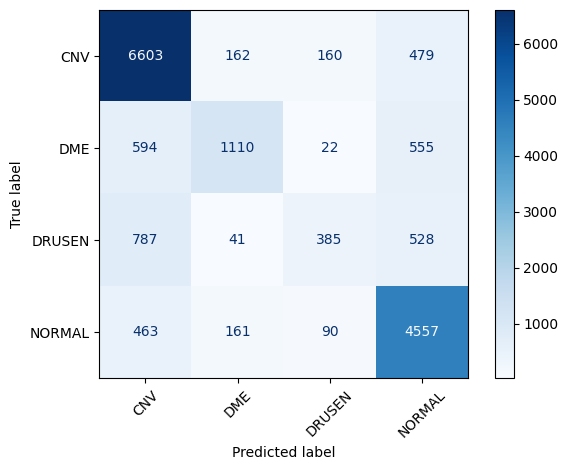

Evaluating Advanced Model...

Classification Report:
              precision    recall  f1-score   support

         CNV       0.92      0.94      0.93      7404
         DME       0.91      0.80      0.85      2281
      DRUSEN       0.87      0.65      0.74      1741
      NORMAL       0.86      0.96      0.91      5271

    accuracy                           0.90     16697
   macro avg       0.89      0.84      0.86     16697
weighted avg       0.90      0.90      0.89     16697


Confusion Matrix:


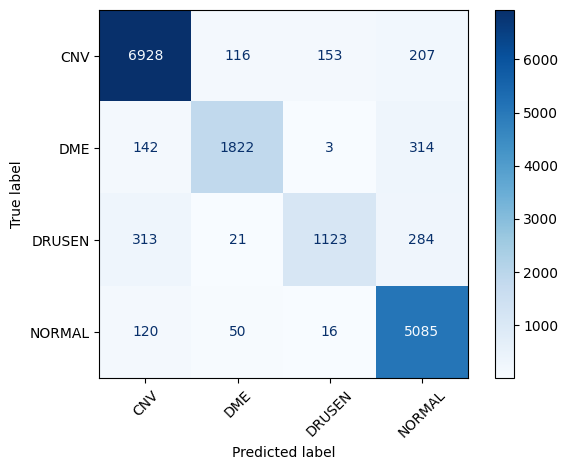

In [48]:
# =================== Training Function ===================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_bar.set_postfix(loss=loss.item(), accuracy=100 * correct/total)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
        with torch.no_grad():
            for images, labels in val_bar:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_bar.set_postfix(val_loss=loss.item(), val_accuracy=100 * val_correct / val_total)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} Summary: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    return history

# =================== Initialize and Train Models ===================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline_model = BaselineModel(len(np.unique(y))).to(device)
advanced_model = AdvancedModel(len(np.unique(y))).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer_baseline = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)
optimizer_advanced = torch.optim.Adam(advanced_model.parameters(), lr=1e-5)

print("Training Baseline Model...")
baseline_history = train_model(baseline_model, train_loader, val_loader, criterion, optimizer_baseline, EPOCHS, device)

print("Training Advanced Model...")
advanced_history = train_model(advanced_model, train_loader, val_loader, criterion, optimizer_advanced, EPOCHS, device)

# =================== Save Model and Training History ===================
torch.save(baseline_model.state_dict(), 'baseline_model.pth')
torch.save(advanced_model.state_dict(), 'advanced_model.pth')

with open('baseline_history.pkl', 'wb') as f:
    pickle.dump(baseline_history, f)

with open('advanced_history.pkl', 'wb') as f:
    pickle.dump(advanced_history, f)

# =================== Evaluation & Reporting ===================
def evaluate_model(model, val_loader, le, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("Evaluating Baseline Model...")
evaluate_model(baseline_model, val_loader, le, device)

print("Evaluating Advanced Model...")
evaluate_model(advanced_model, val_loader, le, device)

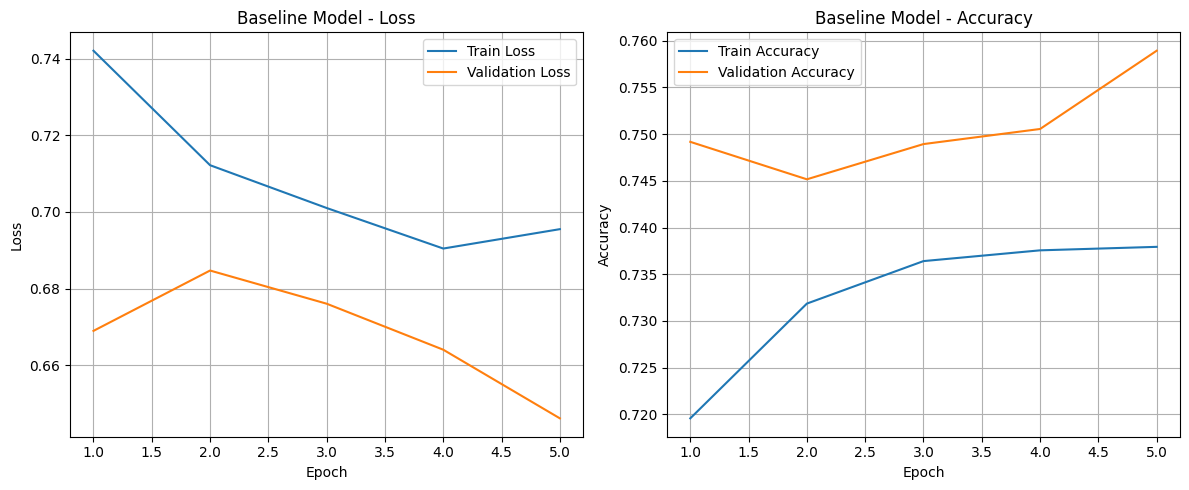

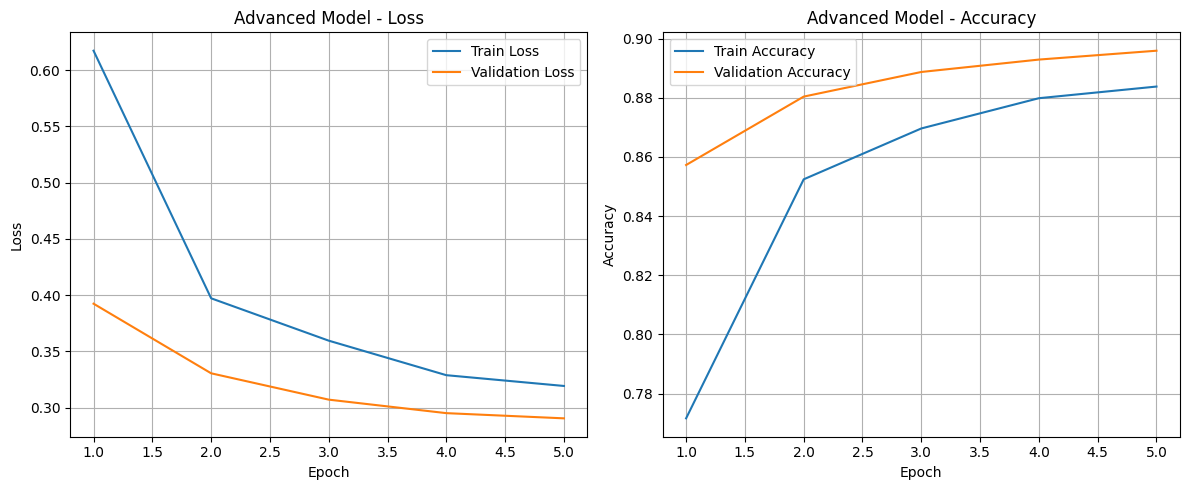

In [49]:
# =================== Plot Training History ===================
def plot_training_history(history, model_name):
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_training_history.png')
    plt.show()

# Tampilkan grafik untuk kedua model
plot_training_history(baseline_history, "Baseline Model")
plot_training_history(advanced_history, "Advanced Model")